## Analysis of classifications

All analysis that only uses the classifications should go here. Excluding IoU or other agreements.

**To Do**
- Class distribution per region and season
- Aqua versus Terra


In [290]:
from pyclouds.imports import *
from pyclouds.helpers import *
from pyclouds.zooniverse import *
from pyclouds.load_config import load_configuration
%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rc("axes.spines", top=False, right=False)
sns.set_context('talk')
sns.set_style('ticks')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [291]:
clas_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_12_16.csv'
subj_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [292]:
clas_prac = split_classification_df(clas_fn, workflow_name='Practice', workflow_version=24.13, drop_nli=True,
                                    subj_df_or_fn=subj_fn)
clas_full = split_classification_df(clas_fn, workflow_name='Full dataset', drop_nli=True, subj_df_or_fn=subj_fn)

In [293]:
annos_prac = convert_clas_to_annos_df(clas_prac)

In [294]:
%time annos_full = convert_clas_to_annos_df(clas_full)

CPU times: user 1min 39s, sys: 20 ms, total: 1min 39s
Wall time: 1min 39s


In [295]:
# Save temporary file
annos_prac.to_csv('/local/tmp/annos_prac.csv')
annos_full.to_csv('/local/tmp/annos_full.csv')

## Basic statistics

### Number of classifications and users

In [296]:
# Number of classifications in each dataset
len(clas_prac), len(clas_full)

(3004, 30310)

In [297]:
# Number of images in each dataset
clas_prac.subject_ids.nunique(), clas_full.subject_ids.nunique()

(53, 9744)

In [298]:
# Roughly split MPI and LMD by date
# This will obvously involve errors.
split_date = np.datetime64('2018-11-28')

In [299]:
# Number of total, MPI and LMD users for 
clas_prac.user_name.nunique(), clas_prac[clas_prac.datetime.dt.date < split_date].user_name.nunique(), clas_prac[clas_prac.datetime.dt.date > split_date].user_name.nunique()

(66, 47, 20)

In [300]:
# Which user labeled in both practice sessions?
set(clas_prac[clas_prac.datetime.dt.date < split_date].user_name.unique()) & set(clas_prac[clas_prac.datetime.dt.date > split_date].user_name.unique())

{'raspstephan'}

It was me! Was just checking in to see if everything was going ok :)

In [301]:
users_MPI = list(clas_prac[clas_prac.datetime.dt.date < split_date].user_name.unique())
users_LMD = list(clas_prac[clas_prac.datetime.dt.date > split_date].user_name.unique())

In [302]:
users_LMD.pop(users_LMD.index('raspstephan'));

In [303]:
clas_full_MPI = clas_full[clas_full.user_name.apply(lambda u: u in users_MPI)]
clas_full_LMD = clas_full[clas_full.user_name.apply(lambda u: u in users_LMD)]

In [304]:
# Number of total, MPI and LMD users
clas_full.user_name.nunique(), clas_full[clas_full.datetime.dt.date < split_date].user_name.nunique(), clas_full[clas_full.datetime.dt.date > split_date].user_name.nunique()

(67, 46, 27)

In [305]:
# Which users did only do the full dataset? And how many classifications did they do?
[(u, len(clas_full[clas_full.user_name == u])) for u in clas_full.user_name.unique() 
  if u not in clas_prac.user_name.unique()]

[('akio', 215),
 ('Serikov', 698),
 ('jvmpi', 292),
 ('SaraShamekh', 9),
 ('Hugo_lmd', 56)]

**TODO** In order to properly split the datasets we also need to assign these users to a group. 

In [306]:
# Which users did only do the practice dataset?
[u for u in clas_prac.user_name.unique() if u not in clas_full.user_name.unique()]

['stefankinne', 'tobifinn', 'UlliK', 'skmueller']

In [307]:
# Number of labels MPI vs LMD
len(clas_prac[clas_prac.datetime.dt.date < split_date]), len(clas_prac[clas_prac.datetime.dt.date > split_date])

(1978, 969)

In [308]:
len(clas_full[clas_full.datetime.dt.date < split_date]), len(clas_full[clas_full.datetime.dt.date > split_date])

(19897, 10410)

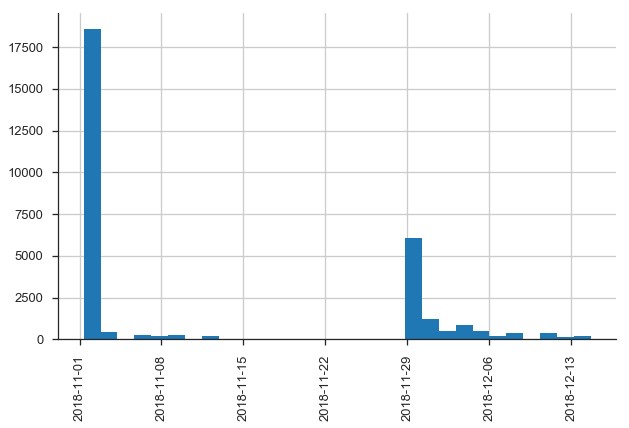

In [309]:
clas_full.datetime.hist(bins=30)
plt.xticks(rotation=90);

### User  statistics

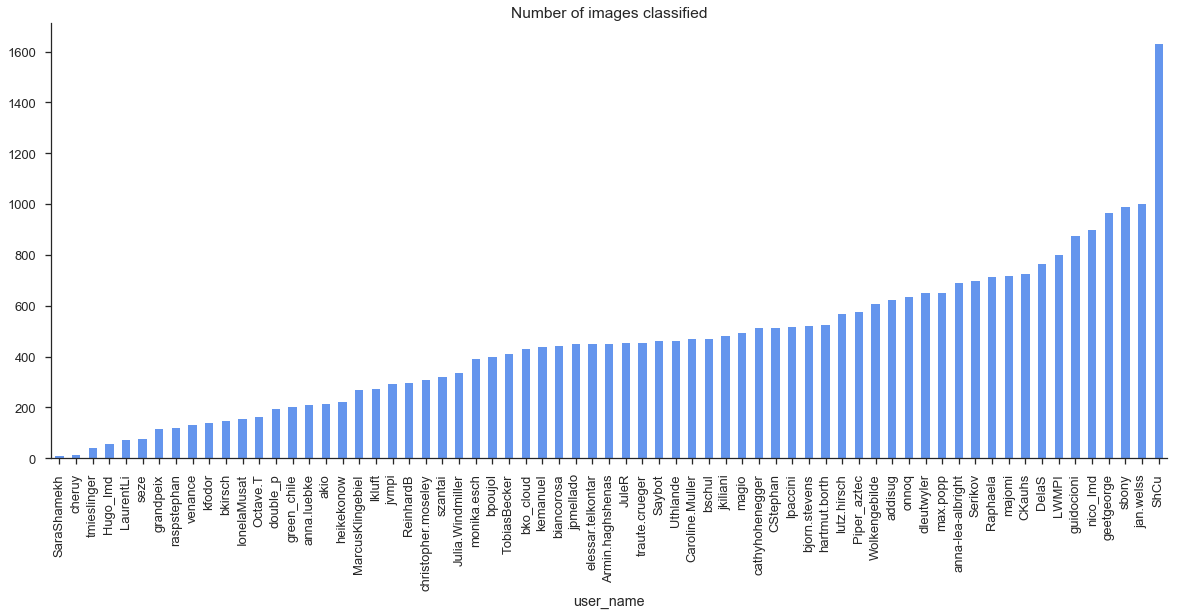

In [310]:
fig = plt.figure(figsize=(20, 8))
clas_full.groupby('user_name').size().sort_values().plot(kind='bar', facecolor='cornflowerblue')
plt.title('Number of images classified');

So Hauke classified by far the most images, but that could have to do with trying around?

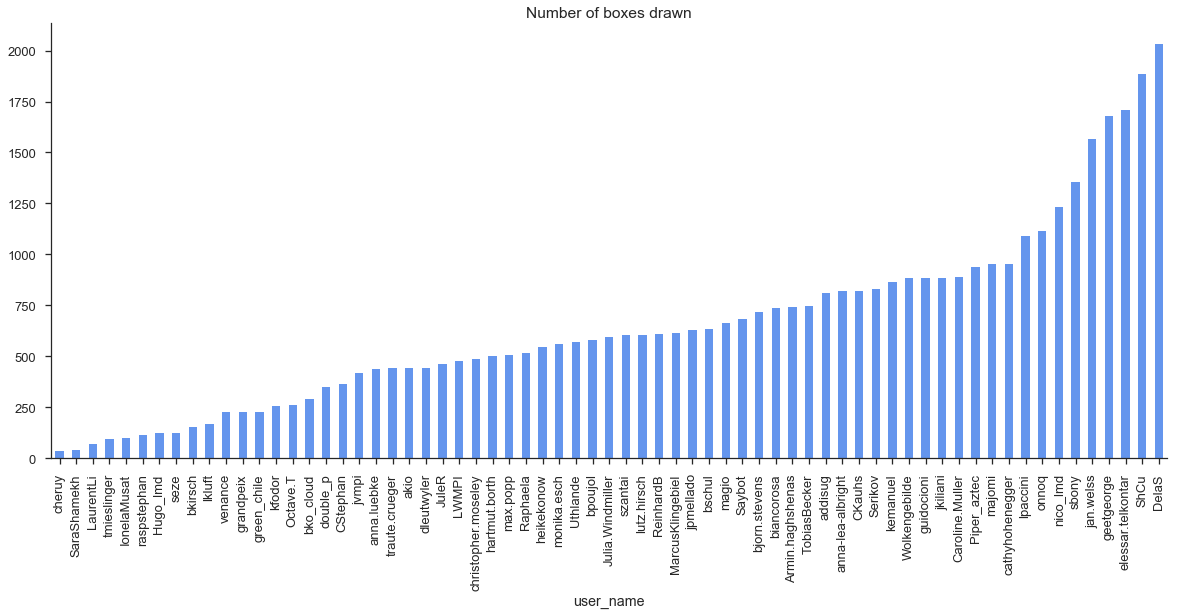

In [311]:
# How many individual boxes
fig = plt.figure(figsize=(20, 8))
annos_full.groupby('user_name').size().sort_values().plot(kind='bar', facecolor='cornflowerblue')
plt.title('Number of boxes drawn');

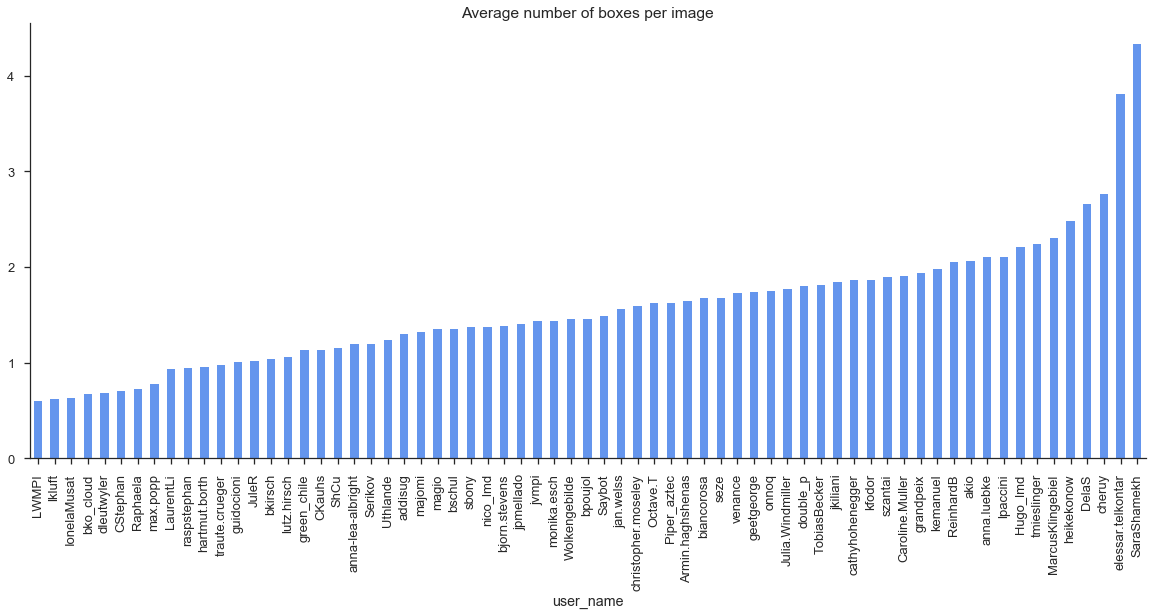

In [312]:
# How many boxes per image
clas_full['num_annos'] = clas_full.annotations.apply(lambda a: len(a['value']))
fig = plt.figure(figsize=(20, 8))
clas_full.groupby('user_name')['num_annos'].mean().sort_values().plot(kind='bar', facecolor='cornflowerblue')
plt.title('Average number of boxes per image');

In [313]:
clas_full.num_annos.max(), clas_full.num_annos.idxmax()

(14, 22221)

Someone put 14 annotations on a single image! Let's check that out later.

In [314]:
num_clas = annos_full.groupby(['user_name', 'tool_label']).count()['subject_ids'].unstack('tool_label')

In [315]:
num_clas['tot_count'] = num_clas.sum(1)
num_clas.head()

tool_label,Fish,Flower,Gravel,Sugar,tot_count
user_name,,,,,
Armin.haghshenas,120,111,249,262,742
CKauhs,156,154,223,289,822
CStephan,40,78,85,159,362
Caroline.Muller,325,189,221,156,891
DelaS,291,249,509,983,2032


In [316]:
num_clas.sort_values('tot_count', inplace=True)

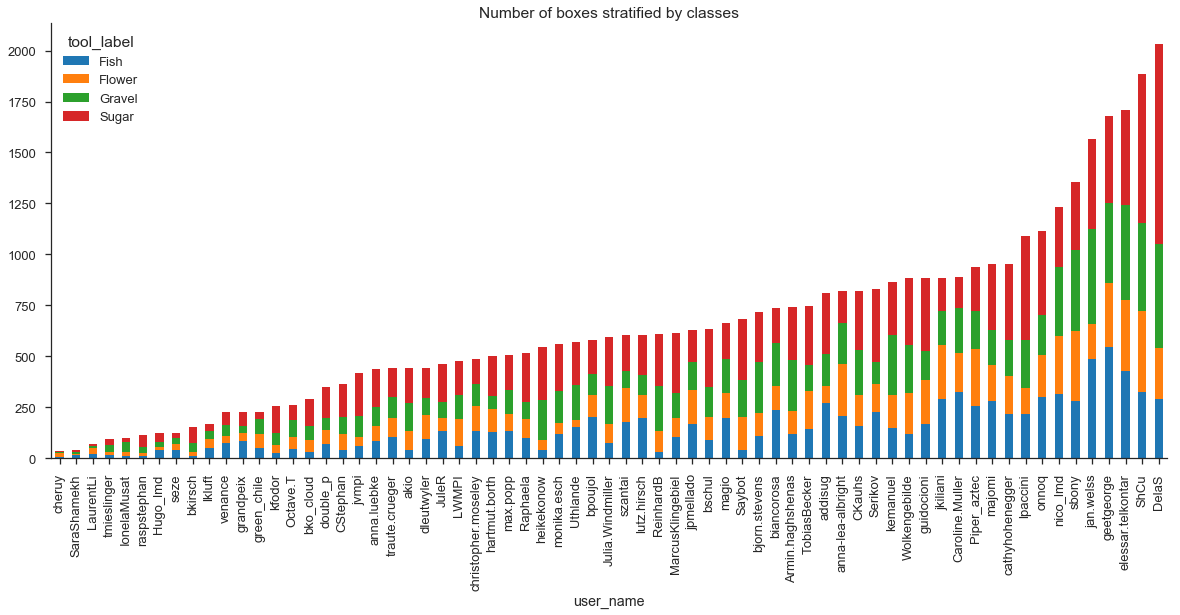

In [317]:
fig, ax = plt.subplots(figsize=(20, 8))
num_clas.iloc[:,:4].plot(kind='bar', stacked=True, ax=ax)
plt.title('Number of boxes stratified by classes');

In [318]:
# Compute time spent labeling
annos_full['time_per_label'] = (annos_full.finished_at - annos_full.started_at).dt.seconds

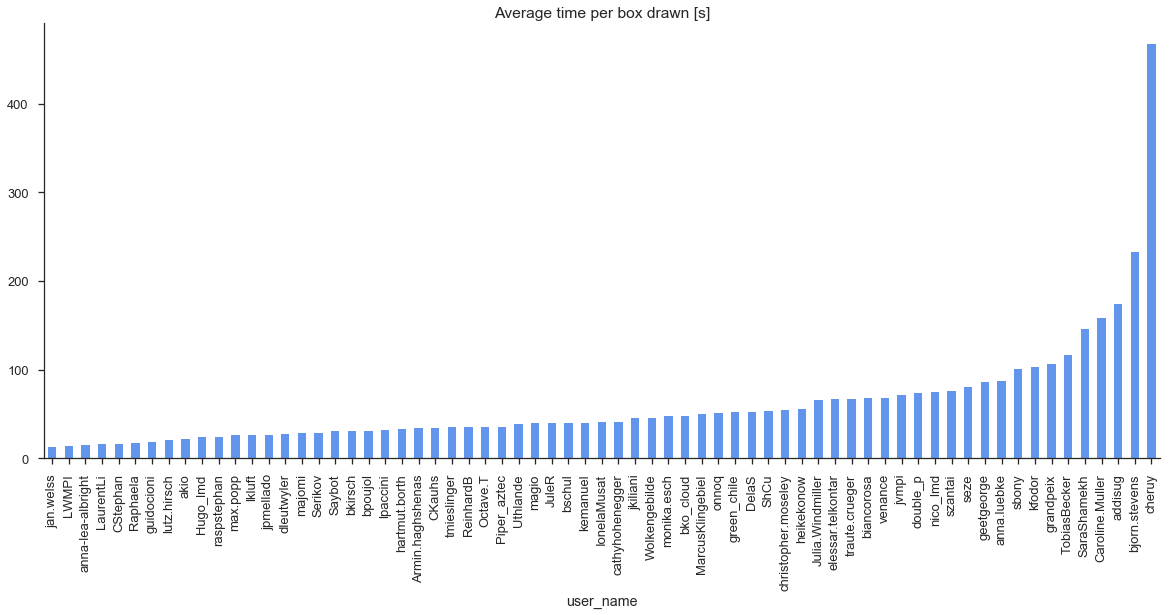

In [319]:
fig, ax = plt.subplots(figsize=(20, 8))
annos_full.groupby('user_name')['time_per_label'].mean().sort_values().plot(kind='bar', facecolor='cornflowerblue')
plt.title('Average time per box drawn [s]');

## Class statistics

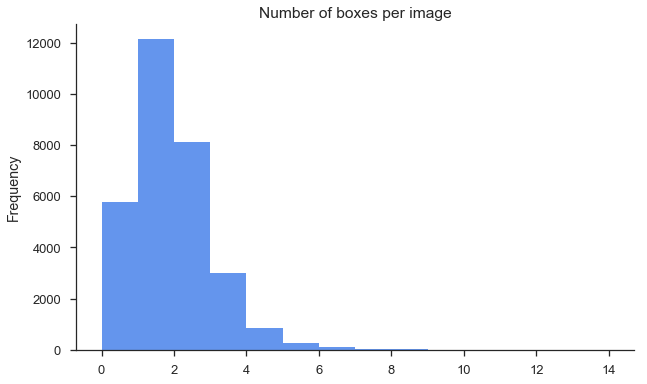

In [320]:
clas_full.num_annos.plot(kind='hist', facecolor='cornflowerblue', bins=range(0, 15))
plt.title('Number of boxes per image');

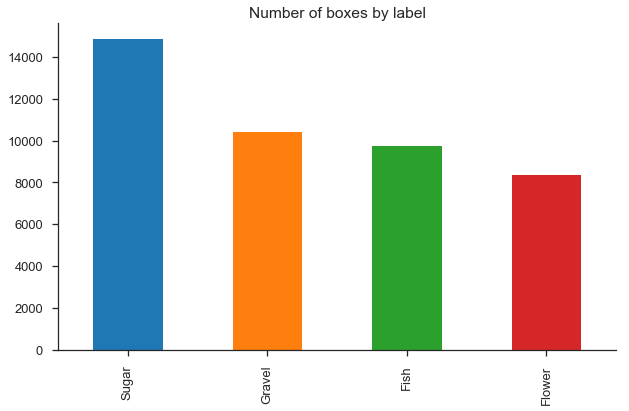

In [321]:
annos_full.tool_label.value_counts().plot(kind='bar')
plt.title('Number of boxes by label');

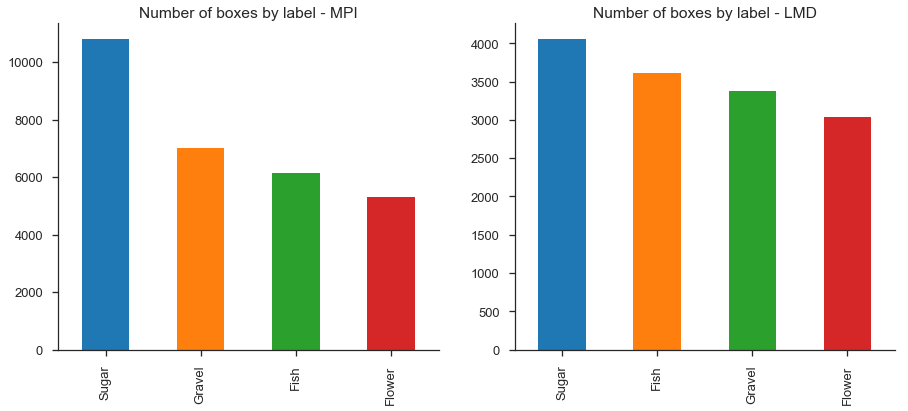

In [322]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
annos_full[annos_full.datetime.dt.date < split_date].tool_label.value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Number of boxes by label - MPI');
annos_full[annos_full.datetime.dt.date > split_date].tool_label.value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Number of boxes by label - LMD');

MPI is significantly more skewed. Was there a difference in explanation?

## Statistics by region and area

In [327]:
#EXPORT
annos_full['subject_set'] = annos_full.subject_set_id.apply(lambda s: subj_id2name[s])

In [323]:
annos_full.subject_set_id.unique()

array([60813.0, 60817.0, 60835.0, 60811.0, 60818.0, 60819.0, 60812.0,
       60816.0, 60814.0, 60815.0], dtype=object)

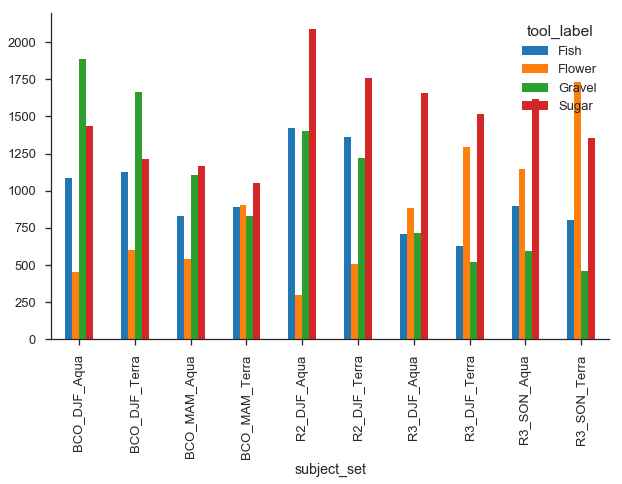

In [331]:
annos_full.groupby(['subject_set', 'tool_label']).size().unstack('tool_label').plot(kind='bar')

In [265]:
clas_full.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids,subject_set_id,datetime,num_annos
28,129486316,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:28:49 UTC,NaN,NaN,"{'source': 'api', 'session': 'f83f28c58ce8e6e9...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27142057': {'retired': None, 'fn': '/project...",27142057,60813,2018-11-01 08:28:49,1
29,129486328,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:29:02 UTC,NaN,NaN,"{'source': 'api', 'session': 'f83f28c58ce8e6e9...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27146798': {'retired': {'id': 24676302, 'wor...",27146798,60817,2018-11-01 08:29:02,1
30,129486340,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:29:18 UTC,NaN,NaN,"{'source': 'api', 'session': 'f83f28c58ce8e6e9...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27163527': {'retired': None, 'fn': '/project...",27163527,60835,2018-11-01 08:29:18,1
31,129486353,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:29:32 UTC,NaN,NaN,"{'source': 'api', 'session': 'f83f28c58ce8e6e9...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27140064': {'retired': {'id': 24667644, 'wor...",27140064,60811,2018-11-01 08:29:32,1
32,129487308,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:40:30 UTC,NaN,NaN,"{'source': 'api', 'session': '7c9ad7c01df71e1f...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27140103': {'retired': {'id': 24667709, 'wor...",27140103,60811,2018-11-01 08:40:30,1


In [225]:
clas_full.subject_data.iloc[0]

{'26976410': {'retired': None,
  'fn': '/project/meteo/work/S.Rasp/cloud-classification/Region1_DJF_Aqua/Aqua_CorrectedReflectance20070103_-61--40_10-24.jpeg',
  'id': '2'}}